In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import hdbscan
import sklearn.cluster as cluster

import napari

from scipy import stats
from skimage.filters import threshold_li, threshold_otsu

import tifffile

In [42]:
##### reading necessary files ####

M = pd.read_csv('./Umap254genesNoDilation.csv',header=None,)
Cell = pd.read_csv('CenterofMass.csv',header=None,)
annot = pd.read_csv("./MouseGenes3.csv",header=None).iloc[:254,1]

print('M: row=cell,col=genes matrix:',M.shape)
print('Cell: XYZ space coordinate of cells:',Cell.shape)
print('annot: gene names:',annot.shape)

M: row=cell,col=genes matrix: (11029, 254)
Cell: XYZ space coordinate of cells: (11029, 3)
annot: gene names: (254,)


In [43]:
######### three input files into one matrix #######
M.columns = annot ### label columns with genes
Cell.columns = ['x','y','z']
m = pd.concat([M,Cell],axis=1) ### add xyz to the matrix
print(m.shape)
m

(11029, 257)


,F2r,Lhx1,Slc38a4,Prom1,Nexn,Rab27b,Midn,Hells,Grsf1,Snu13,...,Efcab6,Hoxb4,Rnf213,Spred2,Cyfip2,Nrcam,Fgfr2,x,y,z
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,3,789.413613,611.352898,43.583693
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,795.262222,547.996667,25.930556
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,793.679558,576.179188,35.571429
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,849.915088,600.801457,39.509677
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,828.988586,621.795104,35.989136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,278.930031,637.047799,593.469882
11025,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,335.080922,714.876154,596.650008
11026,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,291.837102,695.601075,598.870125
11027,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,302.786475,619.632200,598.052271


In [137]:
def filter_matrix(m_xyz_df, tcell, tgene, norm=False):
    mx = m_xyz_df.iloc[:,:-3]
    mcell = m_xyz_df[['x','y','z']]
    
    #### cells with low count ####
    cell_rm = np.sum(mx,axis=1)<=tcell
    print('removed cell count:', str(np.sum(cell_rm)))
    
    ### genes with low counts ####
    gene_rm = np.sum(mx,axis=0)<=tgene
    print('removed gene count:', str(np.sum(gene_rm)))        
    
    ### remove ##
    mx_filter = mx.iloc[~cell_rm.values,~gene_rm.values]

    ##### normalize ####
    if norm==True:
        mx_norm = mx_filter.div(mx_filter.sum(axis=1), axis=0)*10_000
    else:
        mx_norm = mx_filter
    #######################
    mcell_filter = mcell.iloc[~cell_rm.values,:]
    o = pd.concat([mx_norm,mcell_filter],axis=1)#.reset_index(drop=True)
    
    return o

x0 = np.log1p(np.sum(m.iloc[:,:-3],axis=0).to_numpy()) #### sum per gene, in log space
thresh_g = threshold_otsu(x0)

Thresh_gene = np.expm1(thresh_g) #### thresh_g is otsu in log space, so revert back to linear space
Thresh_cell = 40    #### = 40

print('Thresh_cell: ',Thresh_cell)
print('Thresh_gene: ',Thresh_gene)

m_norm = filter_matrix(m,tcell=Thresh_cell,tgene=Thresh_gene,norm=True).reset_index(drop=True)       # filters and normalizes sum per cell = 10_000, ie. assumes constant 'total RNA' per cell


Thresh_cell:  40
Thresh_gene:  260.8174204449091
removed cell count: 484
removed gene count: 68


(10545, 185)


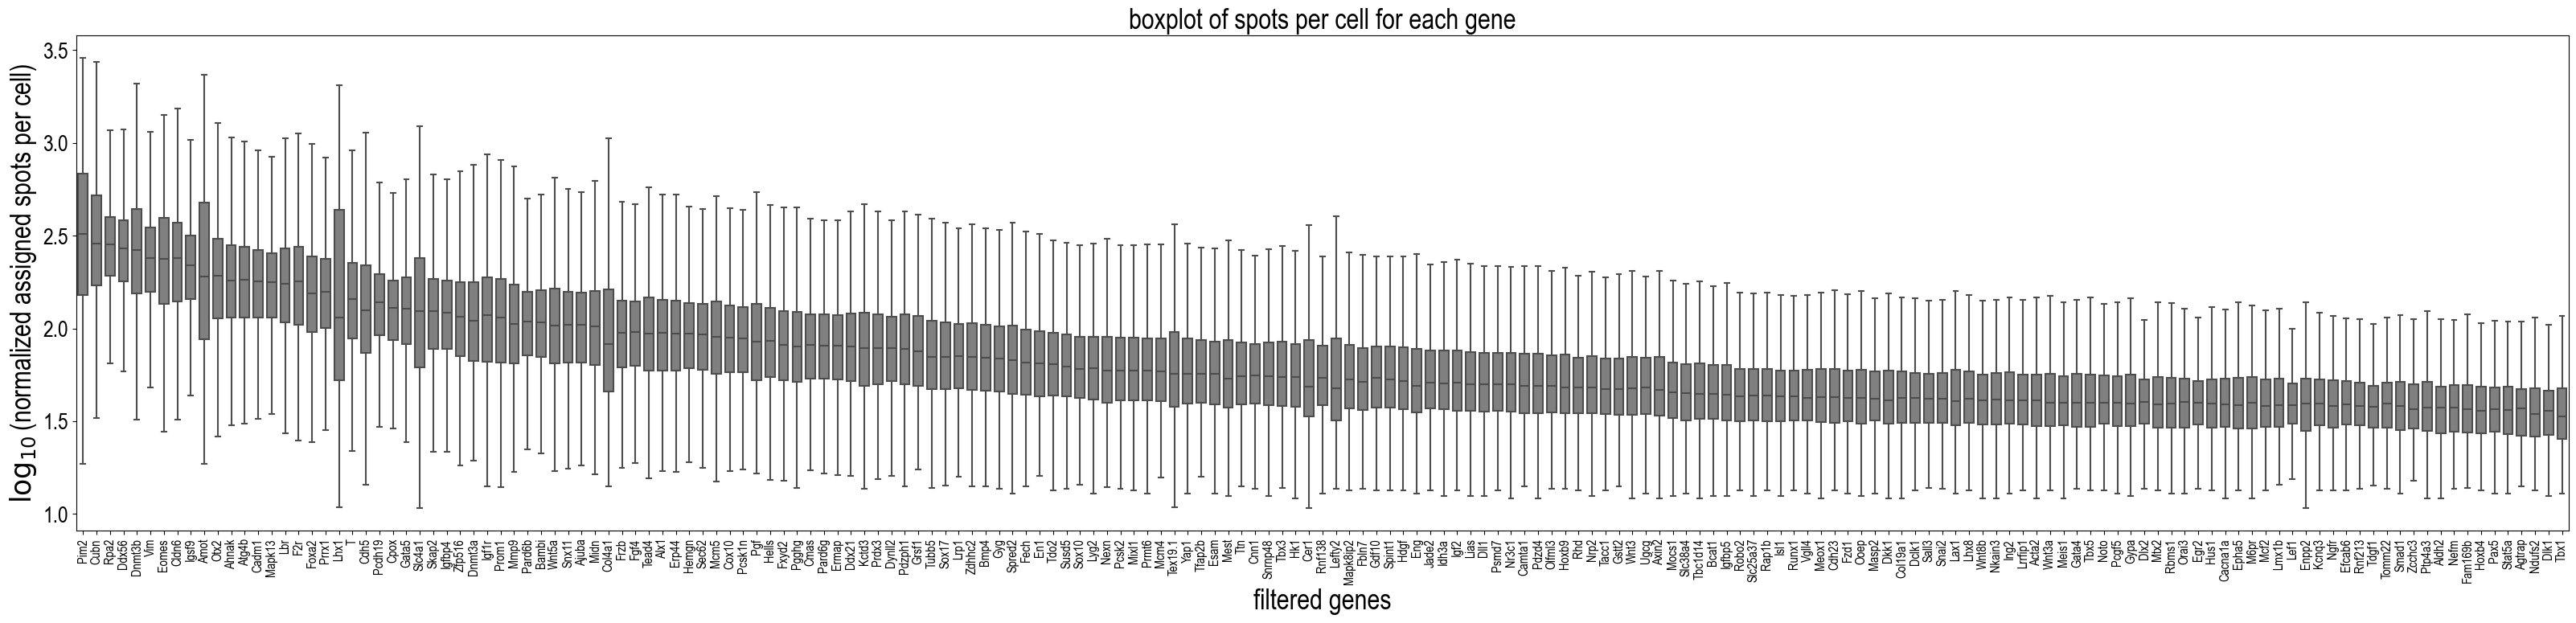

In [142]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.stretch'] = 'condensed'

b = m_norm.iloc[:,:-4].copy()

b[b==0] = np.nan
a=b.apply(np.log10)
a_sort = a.iloc[:,np.argsort(np.nanmean(a,axis=0))[::-1]]


f = plt.figure(figsize=(40,8))
print(a_sort.shape)
sns.boxplot(a_sort,color='Grey',showfliers=False,width=0.7)

#sns.violinplot(a_sort,inner='box',fill=False,width=10,linewidth=0.1,color='grey')
plt.xticks(rotation=90,fontsize=11.5)
plt.yticks(fontsize=20)
plt.xlabel('filtered genes',fontsize=25)
plt.ylabel('$\log_{10}$(normalized assigned spots per cell)',fontsize=25)
plt.title('boxplot of spots per cell for each gene',fontsize=25)
#plt.ylabel('log10(normalized counts per cell)',fontsize=15)
plt.show()

In [145]:
############## assign genes to clusters ##################
### need cluster information from previous umap ###
embedding_labels = pd.read_csv('./UMAP_notebook/otsu_min40_neighbor400_c160_s16_UMAP_labels_clusterswap.csv',header=None)
embedding_labels.columns = embedding_labels.columns = ['UMAP 1', 'UMAP 2', 'clusters','clusters_swap']
labels = embedding_labels.clusters_swap
labels

0        6
1        8
2       -1
3        8
4        8
        ..
10540    7
10541    8
10542    7
10543    7
10544   -1
Name: clusters_swap, Length: 10545, dtype: int64

In [119]:
############## assign genes to clusters ##################
def assign_gene_to_cluster(m_xyz_df, cluster_labels):
    mx = m_xyz_df.iloc[:,:-3].reset_index(drop=True)
    uniq_C = np.unique(cluster_labels) # returns sorted unique values, ie unique clusters: -1 to n
    #### make a cluster x gene matrix, where gene is averaged per each cluster
    cluster_mean_lst = []
    for i in range(len(uniq_C)):
        Mx_c = mx.loc[cluster_labels==uniq_C[i],:] # subset cells in a cluster
        ci_mean = np.nanmean(Mx_c,axis=0) # calculate average per gene
        cluster_mean_lst.append(ci_mean)
    cluster_mean = np.stack(cluster_mean_lst,axis=0)   # row=clusters, # col=gene -> avg expression for each cluster

    # assign each gene to one of the clusters: the cluster which has the highest average per cell spot-counts
    assignment_lst = []
    for g in range(cluster_mean.shape[1]):
        v = cluster_mean[:,g]
        if np.max(v) == 0:
            assignment_lst.append('nan') # dealing with genes with 0 counts, in case unfiltered data was used
        else:
            v_max = np.max(np.delete(v,0))   # do not assign to the first cluster = unclustered, only to one of the valid clusters
            v_max_ind = np.where(v==v_max)[0][0]  # grab the first element, if multiple clusters have max expression, the gene will be assigned to the lower number cluster
            assignment_lst.append(v_max_ind-1) # will do -1, because clusters start from -1 to n, with -1 being unclustered
            if np.sum(v==v_max)>1:   # print gene name if more than one cluster have the same maximum
                print(Mx_c.columns[g])


    
    df = pd.DataFrame(np.transpose(cluster_mean))   # transpose such that genes are rows, clusters are columns    
    df.columns = uniq_C  # label columns with uniq clusters label
    df['gene'] = mx.columns # add a column with gene labels
    df['assigned_cluster'] = assignment_lst
    return(df)
    
m_norm_assign = assign_gene_to_cluster(m_norm,labels)
m_norm_assign

,-1,0,1,2,3,4,5,6,7,8,gene,assigned_cluster
0,172.932346,228.989920,213.261894,228.612435,404.599792,209.118064,74.172838,76.810892,58.102226,89.885806,F2r,3
1,160.033293,19.114365,56.732122,759.712010,127.817387,7.984070,553.911011,51.574459,11.086990,45.583649,Lhx1,2
2,4.734476,2.720387,3.406250,9.096590,12.033062,13.699053,1.163611,0.358805,3.330643,1.203037,Slc38a4,4
3,88.138132,146.655160,125.919272,51.087594,18.540017,56.454237,68.664130,9.904477,7.963087,9.499840,Prom1,0
4,27.135686,20.004639,18.012090,37.007470,19.487270,22.488347,41.436197,26.430870,57.912884,51.962112,Nexn,7
...,...,...,...,...,...,...,...,...,...,...,...,...
181,2.597056,2.602302,2.538881,2.782379,2.848236,1.782922,1.361651,0.956017,0.971331,2.039665,Efcab6,3
182,1.877325,2.087342,3.368019,2.966850,0.795427,0.682968,1.456009,0.564329,0.439921,1.526239,Hoxb4,1
183,2.797382,3.195364,3.458141,2.840396,3.195393,1.433785,2.694893,1.335429,0.824512,2.499740,Rnf213,1
184,37.749676,49.707973,47.411761,43.271681,46.610921,48.546953,20.411427,23.406135,10.229945,22.171044,Spred2,0


In [148]:
dat1

,-1,0,1,2,3,4,5,6,7,8,gene,assigned_cluster
184,37.749676,49.707973,47.411761,43.271681,46.610921,48.546953,20.411427,23.406135,10.229945,22.171044,Spred2,0
156,1.261031,2.390037,1.788959,1.909045,0.857118,0.648124,1.103064,0.684185,0.308080,0.894761,Zcchc3,0
158,9.855525,11.172518,10.485671,9.869126,5.777795,7.397250,8.515201,6.133652,3.409052,8.311865,Robo2,0
123,34.513546,37.727345,35.334219,33.959496,32.093452,34.325406,36.440857,29.774445,29.760978,32.488589,Lyg2,0
71,278.385656,501.755899,377.785053,232.907086,124.407383,168.599031,248.997996,156.313653,70.615708,134.755272,Dnmt3b,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65,1.225177,1.260600,1.010674,1.648313,0.629880,0.704403,6.246068,1.616582,2.643711,7.623666,Ndufs2,8
119,5.730952,4.825932,5.546885,5.632827,4.428762,3.163421,6.103802,3.848549,3.032676,6.413462,M6pr,8
125,44.773852,43.059278,46.418517,40.088792,44.985175,45.259826,49.228778,33.472438,36.311648,55.651370,Bmp4,8
88,9.269022,11.248118,10.319320,12.216630,7.027881,5.679415,11.602819,6.067046,6.849162,12.224393,Slc25a37,8


In [153]:
np.array([*range(nclusters)])

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

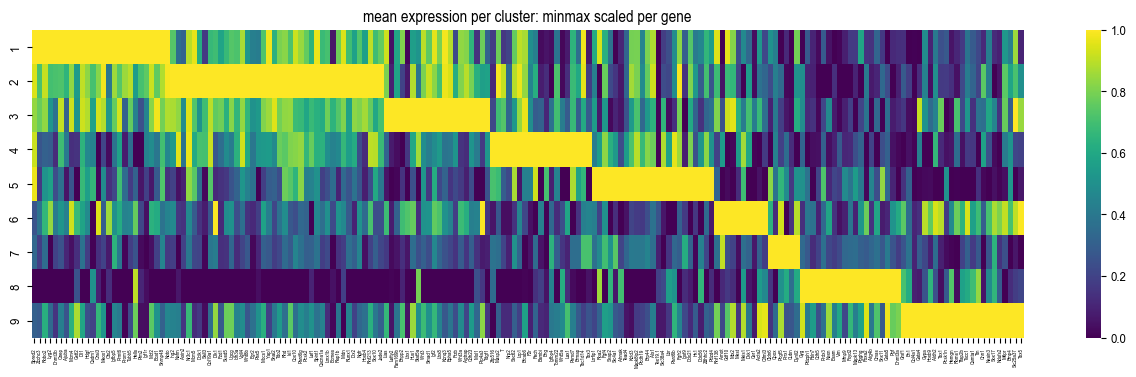

In [154]:
############# heatmap visualization #######################
dat = m_norm_assign.copy()
nclusters = dat.shape[1]-3   # number of clusters is columns number - 3 (-1 cluster, gene, assigned_cluster columns)
dat1 = dat.sort_values(by='assigned_cluster',ascending=True)

###### min max scaling per cluster ####
v = np.transpose(np.array(dat1.iloc[:,1:(nclusters+1)]))  # grab clusters
v_normed = (v-v.min(axis=0)) / (v.max(axis=0)-v.min(axis=0))     # min max normalization per gene, highest cluster = 1, lowset = 0

######## plot ############
f = plt.figure(figsize=(16, 4))
xlabs = dat1['gene']
ylabs = np.array([*range(nclusters)])+1  # we will use 1 base system for labeling

ax = sns.heatmap(v_normed,cmap='viridis', xticklabels=xlabs,yticklabels=ylabs)
ax.set_xticklabels(ax.get_xticklabels(), size = 4)

ax.set_title('mean expression per cluster: minmax scaled per gene')

plt.show()